In [2]:
import nltk, re, pickle, os
import pandas as pd
import numpy as np


from textblob import TextBlob
from nltk.tokenize import sent_tokenize, word_tokenize, wordpunct_tokenize, MWETokenizer
from nltk.stem import porter, WordNetLemmatizer

from nltk.corpus import stopwords
from nltk.util import ngrams

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation,  TruncatedSVD, NMF
from sklearn.neighbors import NearestNeighbors

#import pyLDAvis, pyLDAvis.sklearn
#from IPython.display import display

from sklearn.preprocessing  import  StandardScaler

import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D

path = '/Volumes/ext200/Dropbox/metis/p4_fletcher/pick/'

In [3]:
#open metadata and cleaned talks

with open(path + 'ted_all.pkl', 'rb') as picklefile:
    ted_all = pickle.load(picklefile)

    
with open(path + 'cleaned_talks.pkl', 'rb') as picklefile:
    cleaned_talks = pickle.load(picklefile)    

# Vectorize + Topic Modeling 
look at tfidf in addition to count vectorizer for topic modeling methods

Count vect: Convert a collection of text documents to a matrix of token counts This implementation produces a sparse representation.

# LDA

In [1]:
def topic_mod_lda(data,topics=5,iters=10,ngram_min=1, ngram_max=3, max_df=0.6, max_feats=5000):
    
    """ vectorizer - turn words into numbers for each document(rows)
    then use Latent Dirichlet Allocation to get topics"""
    
    
    vectorizer = CountVectorizer(ngram_range=(ngram_min,ngram_max), 
                             stop_words='english', 
                             max_df = max_df, 
                             max_features=max_feats)
    
      
    #  `fit (train), then transform` to convert text to a bag of words

    vect_data = vectorizer.fit_transform(data)
    
    
    
    lda = LatentDirichletAllocation(n_components=topics,
                                    max_iter=iters,
                                    random_state=42,
                                    learning_method='online',
                                    n_jobs=-1)
    
    lda_dat = lda.fit_transform(vect_data)
    
    
    # to display a list of topic words and their scores 
    
    def display_topics(model, feature_names, no_top_words):
        for ix, topic in enumerate(model.components_):
            print("Topic ", ix)
            print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
    
    display_topics(lda, vectorizer.get_feature_names(),20)
    
    
    return vectorizer, vect_data, lda, lda_dat

best yet 
cleaned_talks,topics=23,
                                     iters=100,
                                     ngram_min=1, 
                                     ngram_max=2, 
                                     max_df=0.4, 
                                     max_feats=2000)

In [4]:
vect_mod, vect_data, lda_mod, lda_data = topic_mod_lda(cleaned_talks,
                                                       topics=20,
                                     iters=100,
                                     ngram_min=1, 
                                     ngram_max=2, 
                                     max_df=0.5, 
                                     max_feats=2000)

Topic  0
woman men child girl family community young black mother sex boy home man country white school story female father gender
Topic  1
food plant water eat farmer product plastic waste grow seed feed farm produce crop egg soil diet eating percent agriculture
Topic  2
universe earth planet space light star science mars physic particle galaxy sun theory billion matter hole black number image away
Topic  3
water ocean specie animal 000 tree sea forest fish earth planet ice area year ago river million coral bird foot shark
Topic  4
country percent money dollar business africa company million market economy billion 000 government cost global economic job india growth china
Topic  5
book word sort picture guy story medium number read page image paper interesting internet wanted write little bit 000 basically somebody
Topic  6
music sound song voice hear em baby listening bee noise listen play hearing ear heard note silence played band speed
Topic  7
love story feel friend man old moment

# for each document, assign the topic (column) with the  highest score from the LDA

In [5]:
topic_ind = np.argmax(lda_data, axis=1)
topic_ind.shape
y=topic_ind

# create text labels for plotting
tsne_labels = pd.DataFrame(y)

# save to csv
tsne_labels.to_csv(path + 'tsne_labels.csv')

In [10]:
topic_names = tsne_labels
topic_names[topic_names==0] = "family"
topic_names[topic_names==1] = "agriculture"
topic_names[topic_names==2] = "space"
topic_names[topic_names==3] = "environment"
topic_names[topic_names==4] = "global economy"
topic_names[topic_names==5] = "writing"
topic_names[topic_names==6] = "sounds"
topic_names[topic_names==7] = "belief, mortality"
topic_names[topic_names==8] = "transportation"

topic_names[topic_names==9] = "gaming"
topic_names[topic_names==10] = "architecture"
topic_names[topic_names==11] = "education"

topic_names[topic_names==12] = "neuroscience"
topic_names[topic_names==13] = "climate, energy"

topic_names[topic_names==14] = "politics"
topic_names[topic_names==15] = "robotics"  
topic_names[topic_names==16] = "disease biology"
topic_names[topic_names==17] = "medicine"
topic_names[topic_names==18] = "technology, privacy"
topic_names[topic_names==19] = "war"

In [11]:
topic_names

,0
0,"belief, mortality"
1,"climate, energy"
2,"technology, privacy"
3,architecture
4,global economy
5,"belief, mortality"
6,"belief, mortality"
7,architecture
8,politics
9,"belief, mortality"


In [12]:
#save text labels to csv and pkl for plotting

topic_names.to_csv(path + 'topic_names.csv')

with open(path + 'topic_names.pkl', 'wb') as picklefile:
    pickle.dump(topic_names, picklefile)

Visualize the first 2 components from the topic modeling (LDA). 
Not really the best way to look at clusters, but a good place to start.

In [8]:
import pyLDAvis, pyLDAvis.sklearn
from IPython.display import display 
    
    # Setup to run in Jupyter notebook
pyLDAvis.enable_notebook()

 # Create the visualization
vis = pyLDAvis.sklearn.prepare(lda_mod, vect_data, vect_mod)

 # Export as a standalone HTML web page
pyLDAvis.save_html(vis, 'lda.html')

# # Let's view it!
display(vis)

/anaconda/lib/python3.5/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
7      15.585274        1       1  0.005882 -0.078949
4       9.309560        1       2  0.109295 -0.068564
14      7.987524        1       3  0.069895 -0.085987
12      6.900363        1       4  0.006737  0.102333
18      6.794293        1       5  0.056892  0.043012
5       6.006289        1       6  0.015308 -0.014689
10      5.438628        1       7  0.012518  0.075937
3       5.407138        1       8  0.016589  0.056563
0       4.822184        1       9  0.077258 -0.228624
2       3.985105        1      10 -0.007261  0.129881
9       3.973987        1      11 -0.056266  0.134987
17      3.957960        1      12  0.071148 -0.087460
11      3.450202        1      13  0.083880 -0.078291
16      3.272524        1      14  0.037802  0.080084
8       3.028973        1      15  0.012690  0.044023
13      2.811471        1      16  0.034649  0.038878
19      2.774401        1      17 -0.002233 -0.164643
1       2.319808        1      18  0.033793  0.051596
15      1.430406        1      19 -0.134770  0.204718
6       0.743910        1      20 -0.443807 -0.154806, topic_info=     Category         Freq           Term        Total  loglift  logprob
term                                                                    
1962  Default  3877.000000          woman  3877.000000  30.0000  30.0000
230   Default  3221.000000          brain  3221.000000  29.0000  29.0000
1546  Default  2873.000000         school  2873.000000  28.0000  28.0000
1648  Default  1544.000000          sound  1544.000000  27.0000  27.0000
289   Default  2306.000000           cell  2306.000000  26.0000  26.0000
310   Default  3620.000000          child  3620.000000  25.0000  25.0000
273   Default  2094.000000            car  2094.000000  24.0000  24.0000
323   Default  2926.000000           city  2926.000000  23.0000  23.0000
984   Default  2650.000000            kid  2650.000000  22.0000  22.0000
742   Default  1814.000000           food  1814.000000  21.0000  21.0000
1189  Default  1151.000000          music  1151.000000  20.0000  20.0000
1933  Default  2648.000000          water  2648.000000  19.0000  19.0000
1511  Default  1212.000000          robot  1212.000000  18.0000  18.0000
418   Default  3959.000000        country  3959.000000  17.0000  17.0000
220   Default  2287.000000           body  2287.000000  16.0000  16.0000
1336  Default  1825.000000           play  1825.000000  15.0000  15.0000
603   Default  1757.000000         energy  1757.000000  14.0000  14.0000
1925  Default  1523.000000            war  1523.000000  13.0000  13.0000
464   Default  2669.000000           data  2669.000000  12.0000  12.0000
1291  Default  1414.000000        patient  1414.000000  11.0000  11.0000
267   Default  1434.000000         cancer  1434.000000  10.0000  10.0000
856   Default  1149.000000           hear  1149.000000   9.0000   9.0000
1131  Default  1584.000000            men  1584.000000   8.0000   8.0000
776   Default  1521.000000           game  1521.000000   7.0000   7.0000
852   Default  1698.000000         health  1698.000000   6.0000   6.0000
112   Default  1639.000000         animal  1639.000000   5.0000   5.0000
495   Default  1946.000000         design  1946.000000   4.0000   4.0000
1908  Default   935.000000          voice   935.000000   3.0000   3.0000
1711  Default  1525.000000        student  1525.000000   2.0000   2.0000
814   Default  1806.000000     government  1806.000000   1.0000   1.0000
...       ...          ...            ...          ...      ...      ...
856   Topic20   345.779943           hear  1149.133913   3.7000  -3.1741
165   Topic20   266.211026           baby   995.577678   3.5820  -3.4356
731   Topic20    56.390791         flower   217.580872   3.5507  -4.9876
1337  Topic20    75.899174         played   313.752738   3.4818  -4.6905
1226  Topic20    93.885803           note   389.443948   3.4784  -4.

# tSNE

a way to reduce dimensionality to three components so that we can visualize where/if there are clusters in document-topic space.


In [9]:
def plot_tsne(X,y,v1=0,v2=0):
    """ pass in the X from pca.transform ,and the corresponding y values and a string to add to the title
    plots the first three PCA directions/eigenvectors with target values as the color
    ___________________________________________________________________"""
 
    fig = plt.figure(1, figsize=(13, 10))
    ax = Axes3D(fig, elev=-150, azim=110)

    # plot transformed values (the three features that we have decomposed to) , colors correspond to target values
    ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y,
               cmap=plt.cm.hot, edgecolor='k', s=50)
    ax.set_title("tSNE Ted Topics ", fontsize=16)
    ax.set_xlabel("1st ",fontsize=16)
    ax.w_xaxis.set_ticklabels([])
    ax.set_ylabel("2nd",fontsize=16)
    ax.w_yaxis.set_ticklabels([])
    ax.set_zlabel("3rd",fontsize=16)
    ax.w_zaxis.set_ticklabels([])
    ax.view_init(v1,v2)

Want to tweak the hyperparameters so that we get the lowest KL divergence

In [10]:
from sklearn.manifold import TSNE

# a t-SNE model
# angle value close to 1 means sacrificing accuracy for speed
# pca initializtion usually leads to better results 
tsne_model = TSNE(n_components=3, verbose=1, random_state=44, angle=.50,
                  perplexity=18,early_exaggeration=1,learning_rate=50.0)#, init='pca'

# 20-D -> 3-D
tsne_lda = tsne_model.fit_transform(lda_data)

[t-SNE] Computing 55 nearest neighbors...
[t-SNE] Indexed 2467 samples in 0.006s...
[t-SNE] Computed neighbors for 2467 samples in 0.288s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2467
[t-SNE] Computed conditional probabilities for sample 2000 / 2467
[t-SNE] Computed conditional probabilities for sample 2467 / 2467
[t-SNE] Mean sigma: 0.114020
[t-SNE] KL divergence after 250 iterations with early exaggeration: 1.455881
[t-SNE] Error after 1000 iterations: 1.227577


In [11]:
tsne_data = pd.DataFrame(tsne_lda)
tsne_data.to_csv(path + 'tsne_lda.csv')

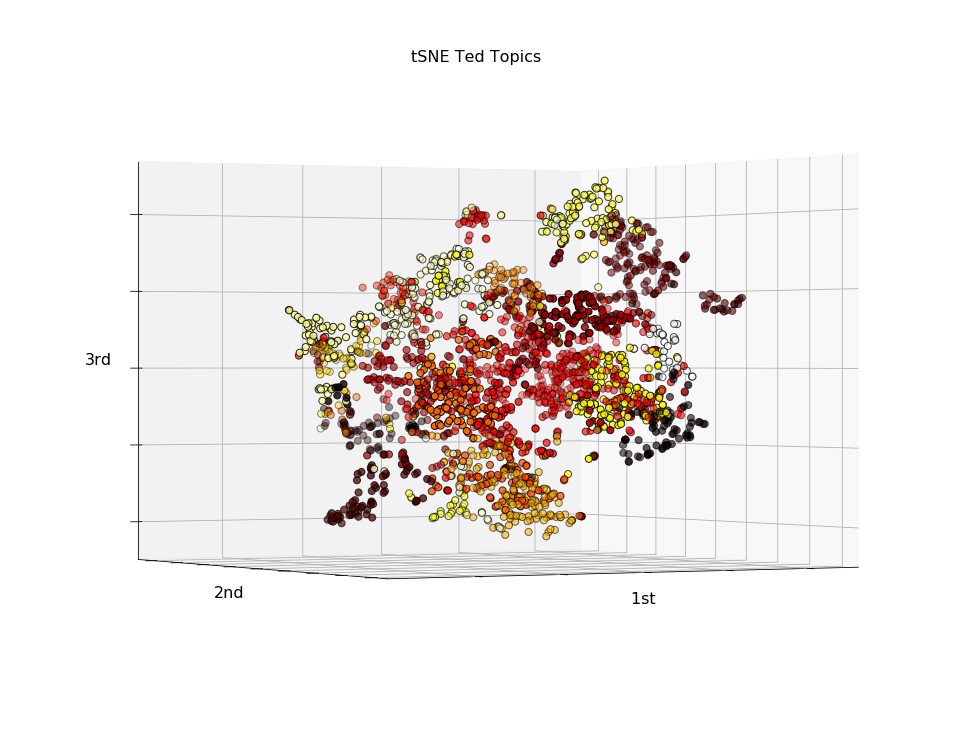

In [12]:
plot_tsne(tsne_lda,y, 0, 60)

# Below are models that gave sub-par results compared to the LDA


# NMF - must do count vectorizer with this one

In [14]:
def topic_mod_nmf(data, topics=5,iters=10,ngram_min=1, ngram_max=3, max_df=0.6, max_feats=5000):
    
    """ vectorizer - turn words into numbers for each document(rows)
    then use Latent Dirichlet Allocation to get topics"""
    
    
    vectorizer = CountVectorizer(ngram_range=(ngram_min,ngram_max), 
                             stop_words='english', 
                             max_df = max_df, 
                             max_features=max_feats)
    
    # call `fit` to build the vocabulary
    vectorizer.fit(data)
    
    # finally, call `transform` to convert text to a bag of words

    x = vectorizer.transform(data)
    
    mod = NMF(n_components=topics,
                max_iter=iters,
                random_state=42)
    
    topiced_dat = mod.fit_transform(x)
    
    
    # to display a list of topic words and their scores 
    
    def display_topics(model_, feature_names, no_top_words):
        for ix, topic in enumerate(model_.components_):
            print("Topic ", ix)
            print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
    
    display_topics(mod, vectorizer.get_feature_names(),20)
    
    
    return mod, vectorizer, x,  topiced_dat

In [15]:
nmf_,vect_mod, vect_data, topic_data  = topic_mod_nmf(cleaned_talks,
                                                             topics=23,
                                                             iters=50,
                                                             ngram_min=1, 
                                                             ngram_max=2, 
                                                             max_df=0.6, 
                                                             max_feats=2000)

Topic  0
love thought feel talk went word started came guy great wanted man person friend experience moment hand old god bit
Topic  1
woman men girl man sex gender boy talk young female violence male mother heart sexual women issue men woman black daughter
Topic  2
brain neuron memory body cell area sleep mind region light animal ability fly control change activity turn study sound behavior
Topic  3
money dollar percent company business problem million market 000 cost value 10 billion buy government pay job better product 20
Topic  4
planet earth mars star atmosphere surface solar sun ago space picture billion year ago ice place 000 million light away far
Topic  5
cell cancer body disease tumor drug blood stem stem cell organ dna tissue gene muscle patient molecule able vessel protein start
Topic  6
school kid student teacher education high class learning teach girl classroom community went high school learn old parent college started grade
Topic  7
city building place space street des

# LSA count vec

In [23]:
def topic_mod_lsa(data, topics=5,ngram_min=1, ngram_max=3, max_df=0.6, max_feats=5000):
    
    """ vectorizer - turn words into numbers for each document(rows)
    then use Latent Dirichlet Allocation to get topics"""
    
    
    vectorizer = CountVectorizer(ngram_range=(ngram_min,ngram_max), 
                             stop_words='english', 
                             max_df = max_df, 
                             max_features=max_feats)
    
    # call `fit` to build the vocabulary
   
    vect_data = vectorizer.fit_transform(data)
    
    #stdScale = Normalizer()

    #vect_scale = stdScale.fit_transform(vect_data)
    
    mod = TruncatedSVD(n_components=topics,random_state=42)
    
    topiced_dat = mod.fit_transform(vect_data)
    
    
    # to display a list of topic words and their scores 
    
    def display_topics(model_, feature_names, no_top_words):
        for ix, topic in enumerate(model_.components_):
            print("Topic ", ix)
            print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
    
    display_topics(mod, vectorizer.get_feature_names(),20)
    
    
    return mod, vectorizer, vect_data

In [24]:
lsa_,vect_mod,lsa_topic_data  = topic_mod_lsa(cleaned_talks,
                                                             topics=23,
                                                             ngram_min=1, 
                                                             ngram_max=2, 
                                                             max_df=0.6, 
                                                             max_feats=2000)

Topic  0
human problem idea change country story percent woman question place child talk fact great start brain better technology thought big
Topic  1
brain cell human technology light body computer animal neuron planet cancer robot space earth data universe able information machine example
Topic  2
brain woman cell men cancer child body girl love patient story neuron disease human mother man feel baby thought word
Topic  3
country cell cancer percent brain disease health patient drug africa government data change problem woman dollar china global growth food
Topic  4
woman water planet cancer cell earth men ocean space universe light energy black mars star galaxy body specie place surface
Topic  5
cancer cell kid school patient disease city drug child design building tumor health started doctor blood went teacher student care
Topic  6
brain child city water school food kid family place area animal planet ocean neuron building earth percent fish country energy
Topic  7
city brain build

# LSA Tfidf

In [25]:
def topic_mod_lsa_t(data, topics=5,ngram_min=1, ngram_max=3, max_df=0.6, max_feats=5000):
    
    """ vectorizer - turn words into numbers for each document(rows)
    then use Latent Dirichlet Allocation to get topics"""
    
    
    vectorizer = TfidfVectorizer(ngram_range=(ngram_min,ngram_max), 
                             stop_words='english', 
                             max_df = max_df, 
                             max_features=max_feats)
    
    vect_data = vectorizer.fit_transform(data)
    
    stdScale = Normalizer()

    vect_scale = stdScale.fit_transform(vect_data)
    mod = TruncatedSVD(n_components=topics,random_state=42)
    
    topiced_dat = mod.fit_transform(vect_scale)
        
    # to display a list of topic words and their scores 
    
    def display_topics(model_, feature_names, no_top_words):
        for ix, topic in enumerate(model_.components_):
            print("Topic ", ix)
            print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
    
    display_topics(mod, vectorizer.get_feature_names(),20)
    
    
    return mod, vectorizer, vect_scale

In [26]:
lsa_,vect_mod,lsa_topic_data  = topic_mod_lsa(cleaned_talks,
                                                             topics=23,
                                                             ngram_min=1, 
                                                             ngram_max=2, 
                                                             max_df=0.6, 
                                                             max_feats=2000)

Topic  0
human problem idea change country story percent woman question place child talk fact great start brain better technology thought big
Topic  1
brain cell human technology light body computer animal neuron planet cancer robot space earth data universe able information machine example
Topic  2
brain woman cell men cancer child body girl love patient story neuron disease human mother man feel baby thought word
Topic  3
country cell cancer percent brain disease health patient drug africa government data change problem woman dollar china global growth food
Topic  4
woman water planet cancer cell earth men ocean space universe light energy black mars star galaxy body specie place surface
Topic  5
cancer cell kid school patient disease city drug child design building tumor health started doctor blood went teacher student care
Topic  6
brain child city water school food kid family place area animal planet ocean neuron building earth percent fish country energy
Topic  7
city brain build